# prepare data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
%matplotlib inline
f='epochs/epoch01_front.mkv'
import  skimage 
from skimage.transform import resize
import keras

Using TensorFlow backend.


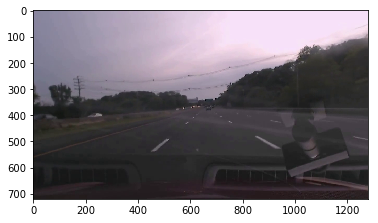

In [2]:
import imageio

reader = imageio.get_reader(f)
plt.imshow(reader.get_data(30))
t0_frame,t1_frame,t2_frame,t3_frame=reader.get_data(0),reader.get_data(1),reader.get_data(2),reader.get_data(3)
t0_frame=np.array(t0_frame)
t1_frame=np.array(t1_frame)
t2_frame=np.array(t2_frame)
t3_frame=np.array(t3_frame)


In [3]:
## Preprocess
def img_pre_process(img):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    ## Chop off 1/3 from the top and cut bottom 150px(which contains the head of car)
    shape = img.shape
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    img=img/255.
    print(img.shape)
    
    ## Resize the image
    resize_img=resize(img, (128, 384), mode='reflect')
    ## Return the image sized as a 4D array
    return resize_img#np.resize(img, (w, h, c))


In [4]:
t0_frame=img_pre_process(t0_frame)
t1_frame=img_pre_process(t1_frame)
t2_frame=img_pre_process(t2_frame)
t3_frame=img_pre_process(t3_frame)


(330, 1280, 3)
(330, 1280, 3)
(330, 1280, 3)
(330, 1280, 3)


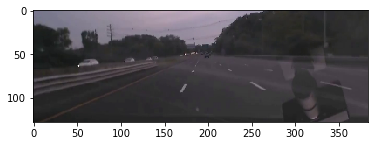

In [5]:

plt.imshow(t3_frame)

In [6]:
steering=pd.read_csv('epochs/epoch01_steering.csv')
t0_steering=steering['wheel'].values[0]
t1_steering=steering['wheel'].values[1]
t2_steering=steering['wheel'].values[2]
t3_steering=steering['wheel'].values[3]

# buid model

In [2]:
from keras.layers import Dense,Deconv2D,Conv2D,BatchNormalization,Activation,Concatenate,Reshape
from keras.engine.topology import Layer

In [3]:
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

In [4]:
def model_input(img_w,img_h,img_c):
    frame_t0=tf.placeholder(tf.float32,(None,img_w,img_h,img_c),name='frame_t0')
    frame_t1=tf.placeholder(tf.float32,(None,img_w,img_h,img_c),name='frame_t1')
    learning_rate=tf.placeholder(tf.float32)
    
    return frame_t0,frame_t1,learning_rate

In [10]:
img_w,img_h,img_c=384,128,3
frame_t0,frame_t1,learning_rate=model_input(img_w,img_h,img_c)

In [15]:
def conv(h_0,filters,kernel_size,strides):
        h1=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(h_0)
        h1_bn=BatchNormalization()(h1,training=True)
        h1_o=Activation(K.relu)(h1_bn)
        return h1_o
def deconv(h_0,filters,kernel_size,strides):
        h1=Deconv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(h_0)
        h1_bn=BatchNormalization()(h1,training=True)
        h1_o=Activation(K.relu)(h1_bn)
        return h1_o


In [16]:
def conv_deconv_net(frame,name, reuse=False,alpha=0.2,):
    with tf.variable_scope(name,reuse=reuse):
        
        ###to deconv
        h10_o=conv(frame,filters=32,kernel_size=3,strides=1)

        h11_o=conv(h10_o,filters=64,kernel_size=3,strides=2)
        ###to deconv
        h20_o=conv(h11_o,filters=64,kernel_size=3,strides=1)
        
        h21_o=conv(h20_o,filters=128,kernel_size=3,strides=2)
        
        ###to deconv
        h30_o=conv(h21_o,filters=128,kernel_size=3,strides=1)
        
        h31_o=conv(h30_o,filters=256,kernel_size=3,strides=2)
        ###to deconv
        h40_o=conv(h31_o,filters=256,kernel_size=3,strides=1)
        
        h41_o=conv(h40_o,filters=512,kernel_size=3,strides=2)
        ###to deconv
        h50_o=conv(h41_o,filters=512,kernel_size=3,strides=1)
        
        h51_o=conv(h50_o,filters=1024,kernel_size=3,strides=2)
        h60_o=conv(h51_o,filters=1024,kernel_size=3,strides=1)
        
        
        #deconv
        d5=deconv(h60_o,filters=512,kernel_size=3,strides=2)
        d4_i=Concatenate(axis=-1)([d5,h50_o])
        
        d4=deconv(d4_i,filters=256,kernel_size=3,strides=2)
        
        d3_i=Concatenate(axis=-1)([d4,h40_o])
        
        d3=deconv(d3_i,filters=128,kernel_size=3,strides=2)
        
        
        
        d2_i=Concatenate(axis=-1)([d3,h30_o])
        
        d2=deconv(d2_i,filters=64,kernel_size=3,strides=2)
        
        
        d1_i=Concatenate(axis=-1)([d2,h20_o])
        
        out=deconv(d1_i,filters=32,kernel_size=3,strides=2)
        
        
        return out,h60_o

In [17]:
def drelu(x):
    x=K.relu(x,max_value=99)
    shape=x.shape.as_list()
    bias=K.ones(shape[-1:])
    x=K.bias_add(x,bias)
    
    
    return x

Activation(drelu)

In [35]:
def depth_net(frame_t0,name='depth_net'):
    top,_=conv_deconv_net(frame_t0,name)
    top=Conv2D(filters=1,kernel_size=1,strides=1,padding='same')(top)
    depth=Activation(drelu)(top)
    
    return depth
    

In [481]:
def unit_test(inputshape,input_num,model):
    input_data=[tf.ones(inputshape) for i in range(input_num)]
    out=model(*input_data)
    sess.run(tf.global_variables_initializer())
    out_=sess.run(out)
    return out,out_
    
    
    

In [482]:
inputshape=[2,384,128,3]
input_num=1
model=depth_net
depth,_=unit_test(inputshape,input_num,model)


In [347]:



class Cloud_transformer():

    def __init__(self, output_dim,intrinsics=[0.5,0.5,1.0], **kwargs):
        self.output_dim = output_dim
        self.cam_intrinsics = intrinsics
        self.build()
        
        
        

    def build(self):
        self.cx_=self.cam_intrinsics[0]
        
        self.cy_=self.cam_intrinsics[1]
        
        self.cf_=self.cam_intrinsics[2]
        
        
        
        self.cx=tf.constant(self.cam_intrinsics[0],dtype=tf.float32)
        
        self.cy=tf.constant(self.cam_intrinsics[1],dtype=tf.float32)
        
        self.cf=tf.constant(self.cam_intrinsics[2],dtype=tf.float32)
        
        
        
        # Create a trainable weight variable for this layer.
        
        
    def mesh_grid(self,width,height):
        x_linspace=tf.linspace(-self.cx_,1-self.cx_,width)
        y_linspace=tf.linspace(-self.cy_,1-self.cy_,height)
        
        x_cord,y_cord=tf.meshgrid(x_linspace,y_linspace)
        
        x_cord=tf.reshape(x_cord,[-1])
        y_cord=tf.reshape(y_cord,[-1])
        
        f_=tf.ones_like(x_cord)
        
        x_=tf.div(x_cord,self.cf)
        y_=tf.div(y_cord,self.cf)
        
        pc2=tf.concat([x_,y_,f_],0)
        return pc2
        
    
        
        
    def transform(self,x):
        
        #get input shape
        batch_size=tf.shape(x)[0]
        width=tf.shape(x)[1]
        height=tf.shape(x)[2]
        channel=tf.shape(x)[3]
        batch_size=tf.cast(batch_size,tf.int32)
        width=tf.cast(width,tf.int32)
        height=tf.cast(height,tf.int32)
        channel=tf.cast(channel,tf.int32)
        
        
        #grid
        grid=self.mesh_grid(width,height)
        pc2=tf.expand_dims(grid,0)
        pc2=tf.reshape(pc2,[-1])
        
        
        pc2 = tf.tile(pc2, tf.stack([batch_size]))
        pc2=tf.reshape(pc2,[batch_size,3,-1])
        
        depth=tf.reshape(x,[batch_size,1,-1])
        depth=tf.concat([depth]*self.output_dim,1)
        
        pc3=tf.multiply(depth,pc2)
#         pc3=tf.reshape(pc3,[batch_size,width,height,self.output_dim])
        
        
        return pc2
        
        
        
    


    def __call__(self, x):
        pc3=self.transform(x)
        return pc3


In [517]:


inputshape=[2,384,128,3]
input_num=1
model=Cloud_transformer(3)
pc3,pc3_=unit_test(inputshape,input_num,model)

In [49]:
def angle_relu(x):
    x=K.relu(x,max_value=2)
    shape=x.shape.as_list()
    bias=K.ones(shape[-1:])
    x=tf.subtract(x,bias)
    
    
    return x



In [420]:
def motion_net(frame_t0,frame_t1,k_obj=4,name='motion'):
    top,embed=conv_deconv_net(frame_t0,name)
    top=Conv2D(filters=k_obj,kernel_size=1,strides=1,padding='same')(top)
    
    
    embed=Dense(512)(embed)
    embed=Dense(512)(embed)
    embed=Reshape([-1])(embed)
    
    
    cam_t_=Dense(3)(embed)
    cam_t=Activation('relu')(cam_t_)
    cam_p=Dense(3)(embed)
    
    cam_p=Activation('relu')(cam_p)
    cam_r=Dense(3)(embed)
    
    cam_r=Activation(angle_relu)(cam_r)
    
    
    
    motion_mask= Activation('sigmoid')(top) 
    motion_t=Activation('relu')(Dense(3*k_obj)(embed))
    motion_t=tf.reshape(motion_t,(-1,k_obj,3))
    motion_p=Activation('relu')(Dense(3*k_obj)(embed))
    motion_p=tf.reshape(motion_p,(-1,k_obj,3))
    
    motion_r=Activation(angle_relu)(Dense(3*k_obj)(embed))
    motion_r=tf.reshape(motion_r,(-1,k_obj,3))
    




    
    return [cam_t,cam_p,cam_r],[motion_t,motion_p, motion_r,motion_mask]


In [502]:

inputshape=[2,384,128,3]
input_num=2
model=motion_net
motios,motios_=unit_test(inputshape,input_num,model)


In [636]:



class Optical_transformer():

    def __init__(self,intrinsics=[0.5,0.5,1.0], **kwargs):
        
        self.cam_intrinsics = intrinsics
        
        
        
        self.cx_=self.cam_intrinsics[0]
        
        self.cy_=self.cam_intrinsics[1]
        
        self.cf_=self.cam_intrinsics[2]
        
        
        
        self.cx=self.np_tf(self.cam_intrinsics[0])
        
        self.cy=self.np_tf(self.cam_intrinsics[1])
        
        self.cf=self.np_tf(self.cam_intrinsics[2])
        
        
        
                # so3
        
        so3_a=np.array([
            [0,-1,0,1,0,0,0,0,0],
            [1,0,0,0,1,0,0,0,0],
            [0,0,0,0,0,0,0,0,1]
        ])

        so3_b=np.array([
            [0,0,1,0,0,0,-1,0,0],
            [1,0,0,0,0,0,0,0,1],
            [0,0,0,0,1,0,0,0,0]
        ])

        so3_y=np.array([
            [0,0,0,0,0,-1,0,1,0],
            [0,0,0,0,1,0,0,0,1],
            [1,0,0,0,0,0,0,0,0]
        ])

#         so3_param=np.concatenate([so3_a,so3_b,so3_y],0)
        self.so3_a=self.np_tf(so3_a)
        self.so3_b=self.np_tf(so3_b)
        self.so3_y=self.np_tf(so3_y)
        

        
#     tool    
    def np_tf(self,array):
        return tf.constant(array,tf.float32)
    
    
    
        
  
    
      
        

    def build(self,cam_motion,obj_motion,x):
                
        self.cam_motion=cam_motion
        
        self.obj_motion=obj_motion
        self.mask_size=obj_motion[0].shape.as_list()[1]
        self.x_shape=x.shape.as_list()
        
        

        
        
        

        
        
#    tranformation     
    def so3_mat(self,sin):
        #input :sin a,sin b,sin y 
        #return : SO3
        sin=tf.expand_dims(sin,-1)
        cos=tf.sqrt(tf.ones_like(sin)-tf.square(sin))
        t=tf.concat([sin,cos,tf.ones_like(sin)],-1)
        t_a=tf.slice(t,[0,0,0],[-1,1,-1])
        t_b=tf.slice(t,[0,1,0],[-1,1,-1])
        t_y=tf.slice(t,[0,2,0],[-1,1,-1])
        t_a=tf.reshape(t_a,(-1,3))
        t_b=tf.reshape(t_b,(-1,3))
        t_y=tf.reshape(t_y,(-1,3))
        
        soa=tf.matmul(t_a,self.so3_a)
        soa=tf.reshape(soa,(-1,3,3))
        
        sob=tf.matmul(t_b,self.so3_b)
        sob=tf.reshape(sob,(-1,3,3))
        soy=tf.matmul(t_y,self.so3_y)
        soy=tf.reshape(soy,(-1,3,3))
        
        
        
        so3=tf.matmul(soy,  tf.matmul(soa,sob))
        return so3
    
    def rigid_motion(self,x,R,p,t):
        p=tf.expand_dims(p,-1)
        t=tf.expand_dims(t,-1)
        
        
        motion=tf.add(tf.matmul(R,tf.subtract(x,p)),t)
        

        return motion
          
 

    
    
    def cam_motion_transform(self,x):
        t,p,sin=self.cam_motion
        R=self.so3_mat(sin)
        X=self.rigid_motion(x,R,p,t)
        
        
        return X
        
  
        
        

    
    
    def obj_motion_transform(self,x_input):
        t,p,sin,mask=self.obj_motion
        
        sin=tf.reshape(sin,(-1,3))
        p=tf.reshape(p,(-1,3))
        t=tf.reshape(t,(-1,3))
        x_in=tf.expand_dims(x_input,1)
        x_exp=tf.concat([x_in]*self.mask_size,1)
        x_=tf.reshape(x_exp,(-1,3,384*128))
        
        
        R=self.so3_mat(sin)
        
        x=self.rigid_motion(x_,R,p,t)
        
        
        
        x=tf.reshape(x,(-1,self.mask_size,3,384*128))
        x=self.mask_motion(x,mask,x_exp)
        X=tf.add(x_input,x)
        
        
        return X
    
    def mask_motion(self,x,mask,x_exp):
        mask=tf.reshape(mask,(-1,self.mask_size,1,384*128))
        x=tf.subtract(x,x_exp)
        x=tf.multiply(x,mask)
        x=tf.reshape(x,(-1,self.mask_size,3,384*128))
        x=tf.reduce_sum(x,1)
        print(x.shape.as_list())
        
        return x
        
        

        

  
    def __call__(self,x,cam_motion,obj_motion,):
        self.build( cam_motion,obj_motion,x)

        
        X=self.obj_motion_transform(x)
        
        
#         X=self.cam_motion_transform(x)
        return X



In [638]:
cam,obj=motios
x=pc3
rgid_=Optical_transformer()(x,cam,obj)

[2, 3, 49152]
x_in [None, 1, 3, None]


In [639]:
rgid_motion=sess.run(rgid_)

In [640]:
rgid_motion.shape

(2, 3, 49152)